In [1]:
import numpy as np
import pandas as pd

import astropy
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.wcs import WCS

from scipy.stats import sigmaclip

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import fitClus2D as fc
from astropy.cosmology import LambdaCDM
%matplotlib inline

from PIL import Image

# These cuts get you a 4x4 arcmin square centered on the image center of the fields
img_cuts = {'a2744':[[519,4520],[412,4413]],
            'm0416':[[367,4368],[380,4381]]}
img_files = {'a2744':'Files/abell2744_RGB.fits',
             'm0416':'Files/macs0416_RGB.fits'}

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}

In [6]:
cluster = 'a2744'
catalog = "Files/" + cluster + "_master2.csv"

#Set up clusters, not clusters, and unknowns
dzcut=0.03; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

clustnum = len(clusterarr)
nclustnum = len(ncluster)
print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))



0.3069860850098326 0.007357462290748165
0.022072386872244495
92
46
236


In [3]:
# Read in RGB file 
RGB = fits.open(img_files[cluster])

# Put separate extensions into own R/G/B arrays
imr=Image.fromarray(RGB[1].data,mode=None) 
img=Image.fromarray(RGB[2].data,mode=None)
imb=Image.fromarray(RGB[3].data,mode=None)

# Merge them back into one image
merged=Image.merge("RGB",(imr,img,imb))

# Conversion factor to translate between x & y and pixels
# In units of arcseconds per pixel
conv = 23.8809/398.015 

# Cut image down to square shape & zoom in since it's a little big
xx = img_cuts[cluster][0] # sets area to cut to
yy = img_cuts[cluster][1]
val = 0 # sets zoom in

imgcut = np.array(merged)[xx[0]+val:xx[1]-val,yy[0]+val:yy[1]-val]

In [23]:
#Set up images
cosmo = LambdaCDM(H0 = 70, Om0 = 0.3, Ode0 = 0.7)
img = fc.imgclass("Files/" + cluster + "_images.dat", zclus[cluster], cosmo)

Read image data from file Files/a2744_images.dat


In [ ]:
f = open("Files/AbellUnknowns.txt", "a")
for gal in unknown:
        f.write(str(gal.master_x) + ", " + str(gal.master_y) + ", " + str(gal.master_x / conv + 2412.5) + ", " + str(gal.master_y / conv + 2519.5) + "\n")
    
f.close()

In [24]:
f = open("Files/AbellCircles.txt", "a")

for gal in unknown:
    f.write("circle " + str(gal.master_x / conv + 2412.5) + " " + str(gal.master_y / conv + 2519.5) + " 20\n")

f.close()

In [25]:
f = open("Files/a2744redshiftcircles.txt", "a")
specs = clusterarr + ncluster
for gal in specs:
    f.write("circle " + str(gal.master_x / conv + 2412.5) + " " + str(gal.master_y / conv + 2519.5) + " 20\n")
    
f.close()

In [26]:
f = open("Files/Abellimgcircles.txt", "a")
for i in img.xarr:
    f.write("circle " + str(i[0] / conv + 2412.5) + " " + str(i[1] / conv + 2519.5) + " 20\n")
    
f.close()

In [10]:
#Ways to assign probabilities
def normalize(X, p):
    copyX = np.copy(X)
    copyp = np.copy(p)
    for i in range((len(X[0]))):
        mn = np.min(X[:,i])
        mx = np.max(X[:,i])
        copyX[:,i] = (X[:,i] - mn) / (mx - mn)
        copyp[:,i] = (p[:,i] - mn) / (mx - mn)
    
    return copyX, copyp
    
def Knn(X, y, p, k):
    normX, normp = normalize(X, p)
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def Rnn(X, y, p, r):
    normX, normp = normalize(X, p)
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def box(X, y, p, numx, numy):
    minm = np.min(Xcm[:,0])
    maxm = np.max(Xcm[:,0])
    minc = np.min(Xcm[:,1])
    maxc = np.max(Xcm[:,1])
    w = maxm - minm
    h = maxc - minc
    minm -= 0.01 * w
    maxm += 0.01 * w
    minc -= 0.01 * h
    maxc += 0.01 * h
    
    boxw = (maxm - minm) / numx
    boxh = (maxc - minc) / numy
    grid = np.zeros((numx, numy, 2))
    
    for i, point in enumerate(X):
        xcoor = int((point[0] - minm) / boxw)
        ycoor = int((point[1] - minc) / boxh)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += y[i]
        
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    for i, point in enumerate(p):
        if point[0] >= minm and point[0] < maxm and point[1] >= minc and point[1] <= maxc:
            xcoor = int((point[0] - minm) / boxw)
            ycoor = int((point[1] - minc) / boxh)
            if not grid[xcoor, ycoor, 1] == 0:
                probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
                if probs[i] > 0.5: classes[i] = 1
                    
    return probs, classes


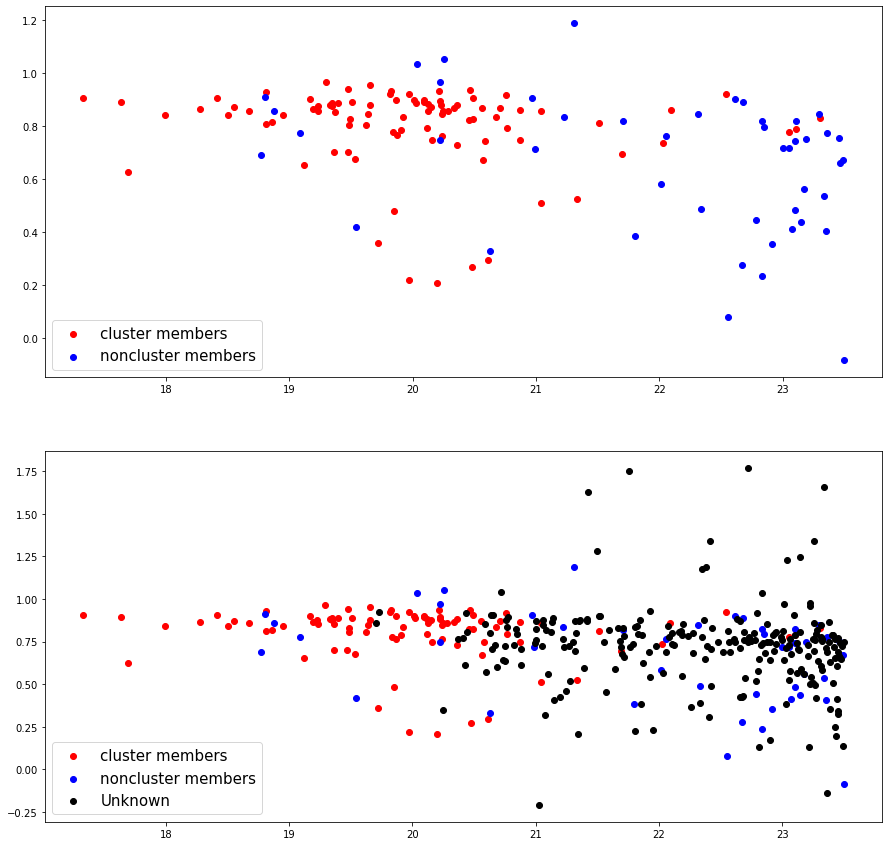

In [11]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(15,15))
ax1.scatter(Xcm[:clustnum,0], Xcm[:clustnum,1], color="red", label = 'cluster members')
ax1.scatter(Xcm[clustnum:,0], Xcm[clustnum:,1], color="blue", label = 'noncluster members')
ax1.legend(loc = "lower left", prop={'size': 15})

ax2.scatter(Xcm[:clustnum,0], Xcm[:clustnum,1], color="red", label = "cluster members")
ax2.scatter(Xcm[clustnum:,0], Xcm[clustnum:,1],color="blue", label = "noncluster members")
ax2.scatter(unknownXcm[:,0], unknownXcm[:,1],color="black", label = "Unknown")
ax2.legend(loc = "lower left", prop={'size': 15})

Text(0.5, 1.0, 'Boxes')

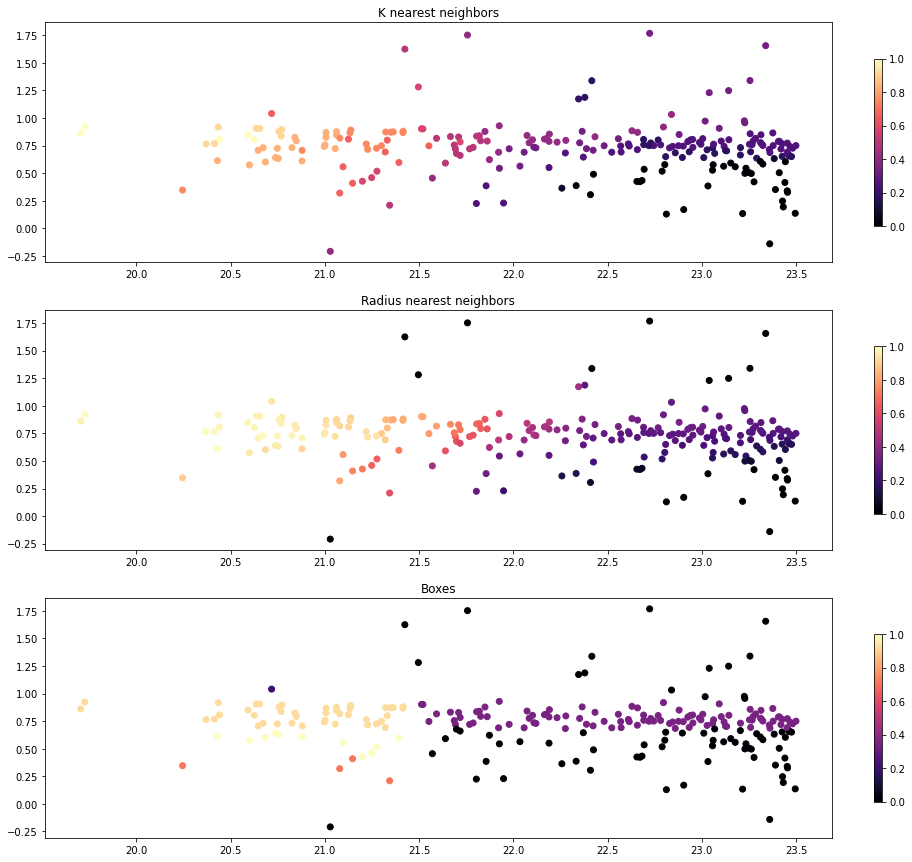

In [12]:
def scatterDraw(ax, results):
    scatter = ax.scatter(unknownXcm[:,0], unknownXcm[:,1], c=results[0], cmap=plt.get_cmap("magma"))
    fig.colorbar(cm.ScalarMappable(cmap="magma"), ax=ax, fraction = 0.01)
    

knnres = Knn(Xcm, y, unknownXcm, 12)
rnnres = Rnn(Xcm, y, unknownXcm, 0.25)
boxres = box(Xcm, y, unknownXcm, 3, 5)

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(15,15))

scatterDraw(ax1, knnres)
ax1.set_title("K nearest neighbors")

scatterDraw(ax2, rnnres)
ax2.set_title("Radius nearest neighbors")

scatterDraw(ax3, boxres)
ax3.set_title("Boxes")

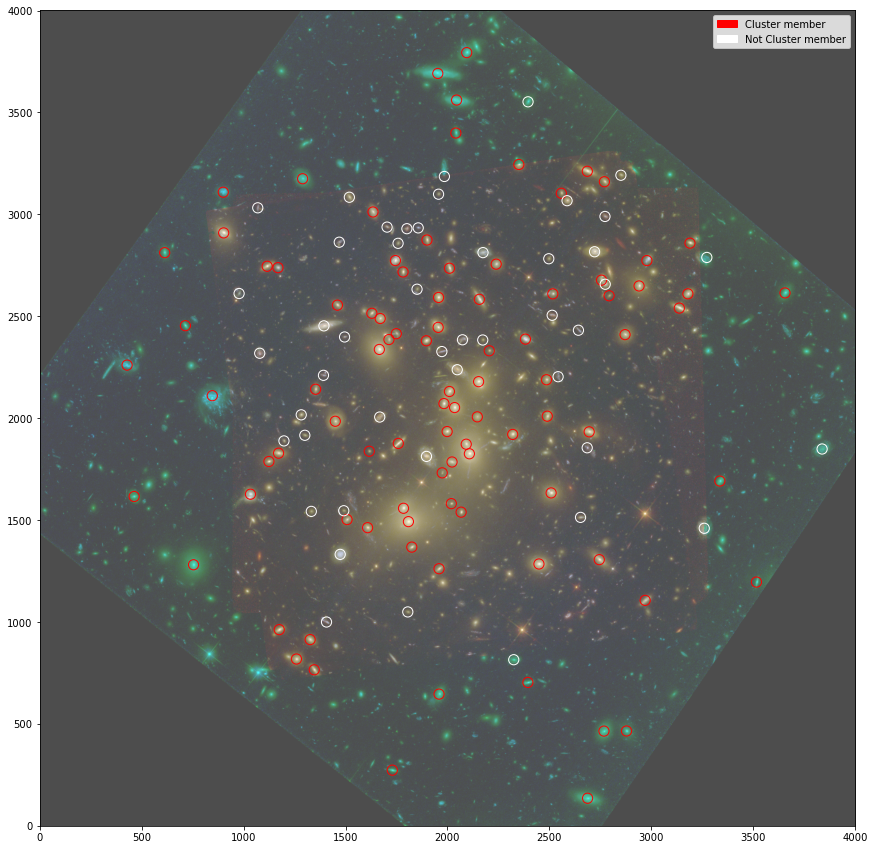

In [13]:


# Plot RGB image
fig,ax = plt.subplots(figsize=(15,15))
plt.imshow(imgcut, origin='lower', alpha = 0.7)


#Plot galaxies
for gal in clusterarr:
    circle = plt.Circle((gal.master_x/conv + (len(imgcut)/2), 
                             gal.master_y/conv + (len(imgcut)/2)), 
                             25, edgecolor = "red", fill=False)
    ax.add_artist(circle)

for gal in ncluster:
    circle = plt.Circle((gal.master_x/conv + (len(imgcut)/2), 
                             gal.master_y/conv + (len(imgcut)/2)), 
                             25, edgecolor = "white", fill=False)
    ax.add_artist(circle)

redpatch = mpatches.Patch(color='red', label='Cluster member')
whitepatch = mpatches.Patch(color='white', label='Not Cluster member')

plt.legend(handles=[redpatch, whitepatch])

plt.show()

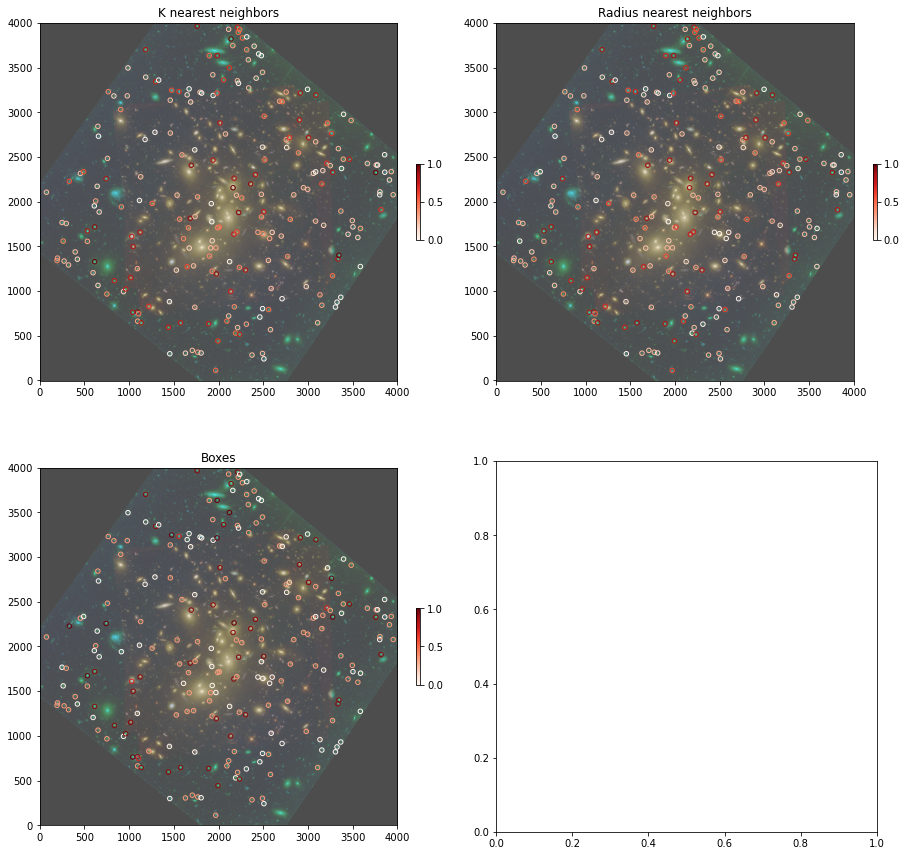

In [14]:
def circlesDraw(ax, res):
    ax.imshow(imgcut, origin='lower', alpha = 0.7)
    for i, gal in enumerate(unknown):
        color = cm.Reds(res[0][i])
        circle = plt.Circle((gal.master_x/conv + (len(imgcut)/2), 
                                 gal.master_y/conv + (len(imgcut)/2)), 
                                 25, edgecolor = color, fill=False)
        ax.add_artist(circle)
    
    fig.colorbar(cm.ScalarMappable(cmap="Reds"), ax=ax, fraction = 0.01)
        
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))

circlesDraw(ax1, knnres)
circlesDraw(ax2, rnnres)
circlesDraw(ax3, boxres)
    

ax1.set_title("K nearest neighbors")
ax2.set_title("Radius nearest neighbors")
ax3.set_title("Boxes")
    
plt.show()

In [15]:
outliers = []
superoutliers = []
for i, gal in enumerate(unknown):
    if unknownXcm[i, 1] > 1.2:
        if unknownXcm[i, 1] < 1.5:
            outliers.append(gal)
        else:
            superoutliers.append(gal)

NameError: name 'clusterr' is not defined

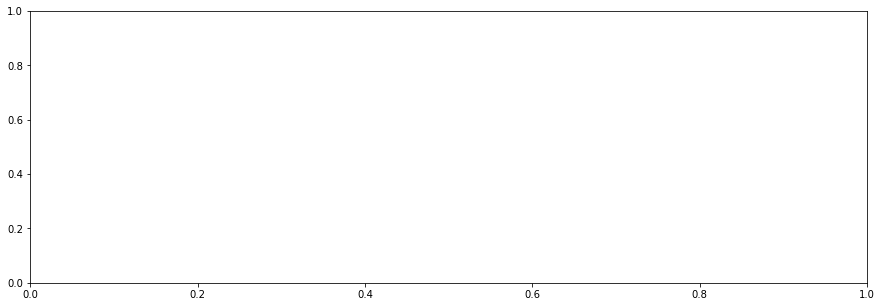

In [16]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.errorbar(Xcm[:clustnum,0], Xcm[:clustnum,1], clusterr, color="red", label = "cluster members", linestyle="None")
ax.errorbar(Xcm[clustnum:,0], Xcm[clustnum:,1], nclusterr, color="blue", label = "noncluster members", linestyle="None")
ax.errorbar(unknownXcm[:,0], unknownXcm[:,1], unknownerr, color="black", label = "Unknown", linestyle="None")
ax.legend(loc = "lower left", prop={'size': 15})

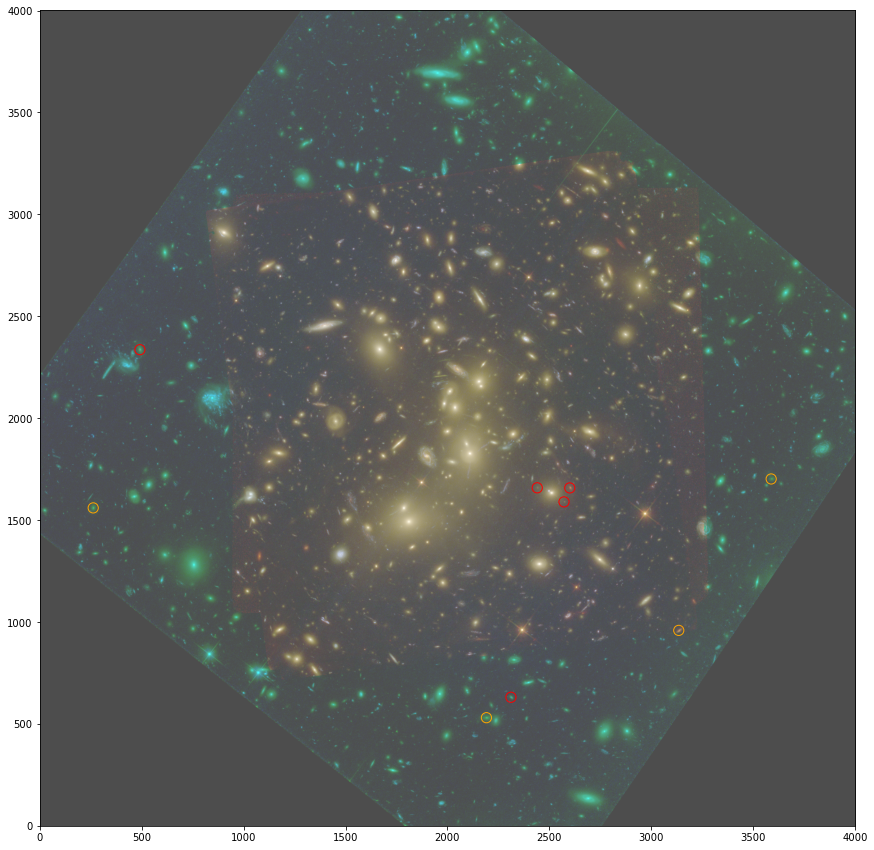

In [17]:
# Plot RGB image
fig,ax = plt.subplots(figsize=(15,15))
plt.imshow(imgcut, origin='lower', alpha = 0.7)


#Plot galaxies
for gal in outliers:
    circle = plt.Circle((gal.master_x/conv + (len(imgcut)/2), 
                             gal.master_y/conv + (len(imgcut)/2)), 
                             25, edgecolor = "red", fill=False)
    ax.add_artist(circle)
    
for gal in superoutliers:
    circle = plt.Circle((gal.master_x/conv + (len(imgcut)/2), 
                             gal.master_y/conv + (len(imgcut)/2)), 
                             25, edgecolor = "orange", fill=False)
    ax.add_artist(circle)


plt.show()